# 6.2 图像卷积
- **目录**
  - 6.2.1 互相关运算
  - 6.2.2 卷积层
  - 6.2.3 图像中目标的边缘检测
  - 6.2.4 学习卷积核
  - 6.2.5 互相关和卷积
  - 6.2.6 特征映射和感受野

## 6.2.1 互相关运算

严格来说，卷积层是个错误的叫法，因为它所表达的运算其实是**互相关运算（cross-correlation）**，而不是卷积运算。
根据第6.1节中的描述，在卷积层中，输入张量和核张量通过**互相关运算**产生输出张量。

首先，我们暂时忽略通道（第三维）这一情况，看看如何处理二维图像数据和隐藏表示。在 图6.2.1中，输入是高度为$3$、宽度为$3$的二维张量（即形状为$3 \times 3$）。卷积核的高度和宽度都是$2$，而卷积核窗口（或卷积窗口）的形状由内核的高度和宽度决定（即$2 \times 2$）。

<center>
    <img src="../img/correlation.svg" alt="二维互相关运算。阴影部分是第一个输出元素，以及用于计算输出的输入张量元素和核张量元素">
</center>
<center>图6.2.1 二维互相关运算：阴影部分是第一个输出元素，以及用于计算输出的输入张量元素和核张量元素$0\times0+1\times1+3\times2+4\times3=19$</center>

在二维互相关运算中，卷积窗口从输入张量的左上角开始，从左到右、从上到下滑动。
当卷积窗口滑动到新一个位置时，包含在该窗口中的部分张量与卷积核张量进行按元素相乘，得到的张量再求和得到一个单一的标量值，由此我们得出了这一位置的输出张量值。
在如上例子中，输出张量的四个元素由二维互相关运算得到，这个输出高度为$2$、宽度为$2$，如下所示：

$$
0\times0+1\times1+3\times2+4\times3=19, 
$$
$$1\times0+2\times1+4\times2+5\times3=25,\tag{6.2.1}
$$
$$3\times0+4\times1+6\times2+7\times3=37,
$$
$$4\times0+5\times1+7\times2+8\times3=43.  
$$

注意，**输出大小略小于输入大小。这是因为卷积核的宽度和高度大于1**，
而卷积核只与图像中每个大小完全适合的位置进行互相关运算。
所以，输出大小等于输入大小$n_h \times n_w$减去卷积核大小$k_h \times k_w$，即：

$$(n_h-k_h+1) \times (n_w-k_w+1).\tag{6.2.2}$$

这是因为我们需要足够的空间在图像上“移动”卷积核。稍后，我们将看到如何通过在图像边界周围填充零来保证有足够的空间移动卷积核，从而保持输出大小不变。
接下来，我们在`corr2d`函数中实现如上过程，该函数接受输入张量`X`和卷积核张量`K`，并返回输出张量`Y`。

- **要点：**
  - 互相关运算（cross-correlation）而非卷积运算是卷积层所表达的实际运算。
  - 输入张量和核张量通过互相关运算产生输出张量。
  - 在二维互相关运算中，卷积窗口从输入张量的左上角开始，从左到右、从上到下滑动。
  - 当卷积窗口滑动到新位置时，包含在该窗口中的部分张量与卷积核张量进行按元素相乘，得到的张量再求和得到一个单一的标量值，由此我们得出了这一位置的输出张量值。
  - 输出大小略小于输入大小，因为卷积核的宽度和高度大于1。输出大小等于输入大小$n_h \times n_w$减去卷积核大小$k_h \times k_w$，即：$(n_h-k_h+1) \times (n_w-k_w+1)$。
  - `corr2d` 函数接受输入张量 `X` 和卷积核张量 `K`，并返回输出张量 `Y`。


In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
def corr2d(X, K):  #@save
    """计算二维互相关运算"""
    h, w = K.shape
    ##结果矩阵的形状，高和宽参考公式6.2.2
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    ##Y的高度和宽度表示卷积核在输入矩阵上下和左右移动的次数
    ##当然这是最简单的情况，没有考虑步幅和填充
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            ##将Y上与卷积核矩阵相同大小的子矩阵与卷积核矩阵按元素相乘得到的矩阵
            ##然后再求和，将和放在结果矩阵上i,j位置
            Y[i, j] = (X[i:i + h, j:j + w] * K).sum()
    return Y

- 通过图6.2.1的输入张量`X`和卷积核张量`K`，验证上述二维互相关运算的输出。


In [3]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
corr2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

## 6.2.2 卷积层

- 卷积层对输入和卷积核权重进行互相关运算，并在添加标量偏置之后产生输出。
- 卷积层中的**两个被训练的参数是卷积核权重和标量偏置。**
- 就像我们之前随机初始化全连接层一样，在训练基于卷积层的模型时，我们也**随机初始化卷积核权重**。
- 基于上面定义的`corr2d`函数**实现二维卷积层**。在`__init__`构造函数中，将`weight`和`bias`声明为两个模型参数。
- 前向传播函数调用`corr2d`函数并添加偏置。


In [4]:
class Conv2D(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(kernel_size))
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        return corr2d(x, self.weight) + self.bias

- 高度和宽度分别为$h$和$w$的卷积核可以被称为$h \times w$卷积或$h \times w$卷积核。
- 我们也将带有$h \times w$卷积核的卷积层称为$h \times w$卷积层。

## 6.2.3 图像中目标的边缘检测

- 下面是**卷积层的一个简单应用：**通过找到像素变化的位置，来**检测图像中不同颜色的边缘**。
- 首先，构造一个$6\times 8$像素的黑白图像。
  - 中间四列为黑色（$0$），其余像素为白色（$1$）。


In [5]:
X = torch.ones((6, 8))
X[:, 2:6] = 0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

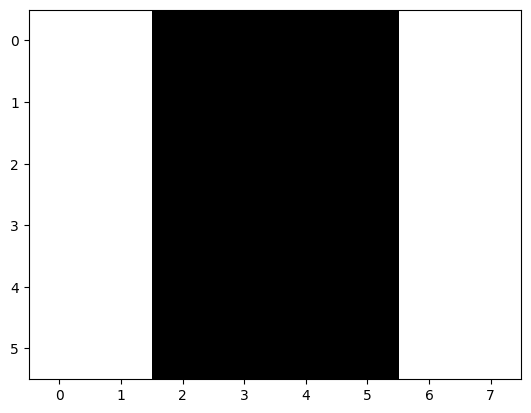

In [6]:
import matplotlib.pyplot as plt
plt.imshow(X,cmap='gray')
plt.show()

- 接下来构造一个高度为$1$、宽度为$2$的卷积核`K`。
- 当进行互相关运算时，如果**水平相邻的两元素相同，则输出为零，否则输出为非零**。


In [7]:
K = torch.tensor([[1.0, -1.0]])

- 现在对参数`X`（输入）和`K`（卷积核）执行互相关运算。
- 如下所示，**输出`Y`中的1代表从白色到黑色的边缘，-1代表从黑色到白色的边缘**，其他情况的输出为$0$。


In [8]:
Y = corr2d(X, K)
Y

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

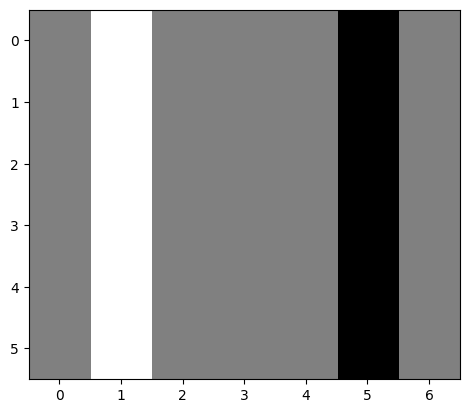

In [9]:
plt.imshow(Y,cmap='gray')
plt.show()

- 现在我们将输入的二维图像转置，再进行如上的互相关运算。
- 其输出如下，之前检测到的垂直边缘消失了。
- 不出所料，这个**卷积核`K`只可以检测垂直边缘**，无法检测水平边缘。


In [10]:
corr2d(X.t(), K)

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

## 6.2.4 学习卷积核

- 如果只需寻找黑白边缘，那么以上`[1, -1]`的边缘检测器足以。然而，当有了更复杂数值的卷积核，或者连续的卷积层时，我们不可能手动设计滤波器。那么我们是否可以[**学习由`X`生成`Y`的卷积核**]呢？

- 现在让我们看看是否可以通过仅查看“输入-输出”对来学习由`X`生成`Y`的卷积核。
  - 先构造一个卷积层，并将其卷积核**初始化为随机张量**。
  - 接下来，在每次迭代中，比较`Y`与卷积层输出的平方误差，然后计算梯度来更新卷积核。
  - 为了简单起见，我们在此使用内置的二维卷积层，并忽略偏置。


In [11]:
# 构造一个二维卷积层，它具有1个输出通道和形状为（1，2）的卷积核
## 与前面的卷积核K的形状一致，但此处是需要学习的参数
conv2d = nn.Conv2d(1,1, kernel_size=(1, 2), bias=False)

# 这个二维卷积层使用四维输入和输出格式（批量大小、通道、高度、宽度），
# 其中批量大小和通道数都为1
X = X.reshape((1, 1, 6, 8))
##Y是检测结果，即垂直边缘
Y = Y.reshape((1, 1, 6, 7))
lr = 3e-2  # 学习率

for i in range(10):
    Y_hat = conv2d(X)
    l = (Y_hat - Y) ** 2
    conv2d.zero_grad()
    l.sum().backward()
    # 迭代卷积核
    conv2d.weight.data[:] -= lr * conv2d.weight.grad
    if (i + 1) % 2 == 0:
        print(f'epoch {i+1}, loss {l.sum():.3f}')

epoch 2, loss 5.352
epoch 4, loss 1.316
epoch 6, loss 0.392
epoch 8, loss 0.136
epoch 10, loss 0.052


- 在$10$次迭代之后，误差已经降到足够低。
- 现在我们来看看我们**所学的卷积核的权重张量**.


In [12]:
##此处的卷积核与真实卷积核已经很接近了，真实卷积核为(1,-1)
conv2d.weight.data.reshape((1, 2))

tensor([[ 1.0129, -0.9673]])

- 细心的你一定会发现，我们**学习到的卷积核权重非常接近我们之前定义的卷积核`K`。**

## 6.2.5 互相关和卷积

回想一下我们在 6.1节中观察到的互相关和卷积运算之间的对应关系。
为了得到正式的卷积运算输出，我们需要执行公式6.1.6中定义的严格卷积运算，而不是互相关运算。
幸运的是，它们差别不大，我们只需**水平和垂直翻转**二维卷积核张量，然后对输入张量执行**互相关运算**。

值得注意的是，由于**卷积核是从数据中学习到的**，因此无论这些层执行严格的卷积运算还是互相关运算，卷积层的输出都不会受到影响。
为了说明这一点，假设卷积层执行互相关运算并学习图6.2.1中的卷积核，该卷积核在这里由矩阵$\mathbf{K}$表示。
假设其他条件不变，当这个层执行严格的**卷积**时，学习的卷积核$\mathbf{K}'$在水平和垂直翻转之后将与$\mathbf{K}$相同。
也就是说，**当卷积层对图6.2.1中的输入和$\mathbf{K}'$执行严格卷积运算时，将得到与互相关运算图6.2.1中相同的输出**。

为了与深度学习文献中的标准术语保持一致，我们将继续把“互相关运算”称为卷积运算，尽管严格地说，它们略有不同。
此外，**对于卷积核张量上的权重，我们称其为元素**。(深度学习称为权重，图像处理称为卷积核元素)。

- **要点：**
  - 卷积层实际上执行的是互相关运算（cross-correlation），而非严格意义上的卷积运算。
  - 为了得到正式的卷积运算输出，需要对卷积核进行水平和垂直翻转，然后再执行互相关运算。
  - 但由于卷积核是从数据中学习到的，因此无论执行严格的卷积运算还是互相关运算，卷积层的输出都不会受到影响。
  - 在深度学习领域，通常将“互相关运算”称为卷积运算，以与文献中的标准术语保持一致。
  - 对于卷积核张量上的权重，我们称其为元素。

------------
- **说明：如何理解“当卷积层对图6.2.1中的输入和执行严格卷积运算时，将得到与互相关运算图6.2.1中相同的输出”？**
  - 在深度学习中，卷积运算和互相关运算虽然定义上有所不同，但在实际应用中，它们之间的差异**不会影响卷积层的学习和输出**。这是因为卷积运算和互相关运算的差异只在于卷积核的翻转。
  - 互相关与卷积的关系：
    - 1. **互相关运算**：是将卷积核直接应用于输入数据，通过滑动窗口机制计算加权和，不进行任何翻转。
    - 2. **卷积运算**：在数学上，卷积运算要求在应用卷积核之前，先将卷积核进行水平和垂直翻转，然后再应用于输入数据。
  - 为什么不影响深度学习中的结果：
    - **学习过程的自适应性**：在深度学习中，卷积核是通过数据驱动的学习过程获得的。优化算法（如梯度下降）会调整卷积核的权重以最小化损失函数。不管用互相关还是卷积，最终学到的卷积核会**自动适应**输入数据的模式。
    - **对称性和翻转**：假设我们使用互相关而不是卷积来学习一个卷积核，记为$\mathbf{K}$。如果我们要用卷积运算得到相同的输出，只需使用翻转后的卷积核$\mathbf{K}'$。由于卷积核是在学习过程中调整的，学习算法会**自动调整到合适的权重**，不论是翻转与否，最终的输出都会相同。
  - 理解过程：
    - 当使用互相关学习到卷积核$\mathbf{K}$时，网络学到的是如何在给定输入上产生期望的输出。
    - 如果我们转而使用严格卷积运算（即翻转后的卷积核$\mathbf{K}'$），在一开始，卷积核会被初始化和调整。由于翻转的性质，在学习过程中，$\mathbf{K}'$会调整到与$\mathbf{K}$翻转后的形式产生相同的效果。
  - 因此，无论使用互相关还是卷积，卷积层在经过训练后，实际应用中产生的输出是一样的，这是因为卷积核的调整会适应所使用的运算方式。
  - 深度学习框架中通常称互相关为卷积，主要是为了与既有的文献和实践保持一致，而不在乎翻转的数学细节，因为这些在实际使用中并不改变结果。
------------------- 

## 6.2.6 特征映射和感受野

如在 6.1.4.1节中所述，图6.2.1中输出的卷积层有时被称为**特征映射（feature map）**，因为它可以被视为**一个输入映射到下一层的空间维度的转换器**。
在卷积神经网络中，对于某一层的任意元素$x$，其**感受野（receptive field）** 是指在前向传播期间可能影响$x$计算的所有元素（来自所有先前层）。

请注意，感受野可能大于输入的实际大小。让我们用 图6.2.1为例来解释感受野：
给定$2 \times 2$卷积核，阴影输出元素值$19$的感受野是输入阴影部分的四个元素。
假设之前输出为$\mathbf{Y}$，其大小为$2 \times 2$，现在我们在其后附加一个卷积层，该卷积层以$\mathbf{Y}$为输入，输出单个元素$z$。
在这种情况下，$\mathbf{Y}$上的$z$的感受野包括$\mathbf{Y}$的所有四个元素，而输入的感受野包括最初所有九个输入元素。
因此，**当一个特征图中的任意元素需要检测更广区域的输入特征时，我们可以构建一个更深的网络**。

----------------

- **说明：感受野的内部机制**
- 示例：三层$3\times 3$卷积核操作之后的感受野是$7\times 7$，其中卷积核的步长(stride)为1，填充(padding)为0
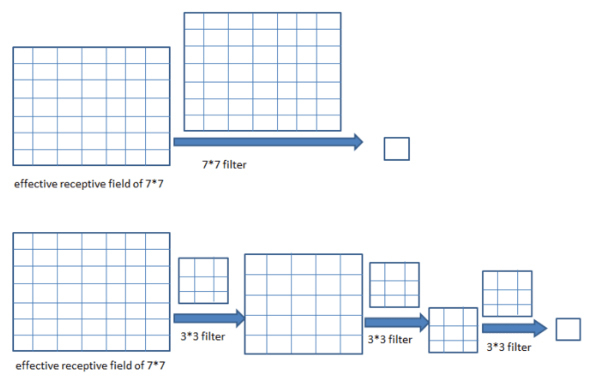

- **具体过程：**
  - 对于$7\times 7$的输入张量，使用$3\times 3$的卷积第1次进行卷积运算之后的结果为$5\times 5$的张量，然后第2次使用$3\times 3$的卷积层进行卷积运算得到$3\times 3$的张量，第3次使用$3\times 3$卷积层得到$1\times 1$的张量。
  - 因此对于感受野的理解主要有几个变量需要清晰：
    - 首先，结果必须是通过卷积运算之后生成只有一个像素（或元素）的张量，比如上图的最右边只有一个元素。
    - 其次确定卷积层的大小，上图是$3\times 3$，即3行3列的张量。
    - 第三，确定卷积运算的层或次数，比如上图是3层。
    - 最后看特定大小卷积层通过n层运算能够将M大的张量缩小为一个元素（或像素）的张量，那么这个M就是感受野的大小。
  - 总结
    - 上图中表述方式可以这样理解，3层$3\times 3$卷积层的感受野是$7\times 7$的张量。
    - 在很多场合下，需要通过输入张量的大小确定需要多少层多大的卷积层对之进行卷积运算；
    - 反过来在卷积层大小和层数确定的情况下，计算其感受野（也就是输入张量）的大小。
    - 当然上图只是一个最简单的例子。如果考虑到步幅和填充，那么感受野的计算将更复杂。

--------

## 小结

* 二维卷积层的核心计算是二维互相关运算。最简单的形式是，对二维输入数据和卷积核执行互相关操作，然后添加一个偏置。
* 我们可以设计一个卷积核来检测图像的边缘。
* 我们可以从数据中学习卷积核的参数。
* 学习卷积核时，无论用严格卷积运算或互相关运算，卷积层的输出不会受太大影响。
* 当需要检测输入特征中更广区域时，我们可以构建一个更深的卷积网络。